### Exploratory Analysis

The main idea is to apply some quantitative trading to the Crypto-sphere and to see if we can create some trading strategies with decent $\alpha$. In the future, it may be possible to run the mutual fund using both algorithmic trading and manual trading (via. Will's domain knowledge).

In order to start algorithmically trading, we need to first decide which currencies that we are willing to trade. We will also need to create a market index to use as the baseline for measuring how well a strategy is actually performing. 


#### Establishing a Market Index

From [Investopedia](https://www.investopedia.com/terms/m/marketindex.asp#ixzz555QvCO80):

> A market index is an aggregate value produced by combining several stocks or other investment vehicles together and expressing their total values against a base value from a specific date. Market indexes are intended to represent an entire stock market and thus track the market's changes over time. 

We will choose coins for the index scaled by their respective market caps; this approach allows us to get a good measurement for the coin markets while keeping the total number of coins in our portfolio small.

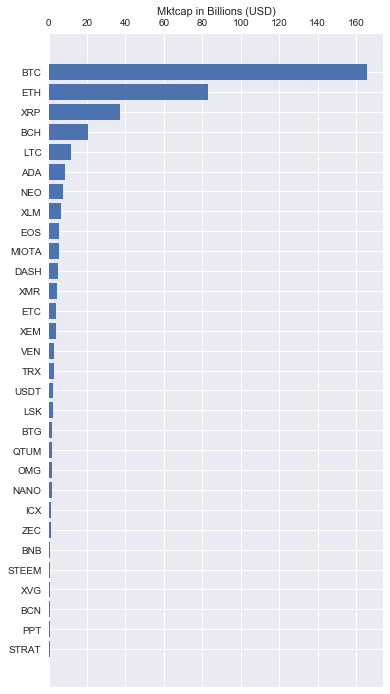

In [6]:
%matplotlib inline
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

N_COINS = 30

df = pd.read_json(f'https://api.coinmarketcap.com/v1/ticker/?limit={N_COINS}')
df = df.infer_objects()

json = requests.get('https://api.coinmarketcap.com/v1/global/').json()
gdf = pd.DataFrame([json]).infer_objects()

fig, ax = plt.subplots(figsize=(6, 12))

ax.barh(df['rank'], df['market_cap_usd']/10**9)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Mktcap in Billions (USD)')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

#ax.set_xticklabels(df["symbol"])

plt.show()


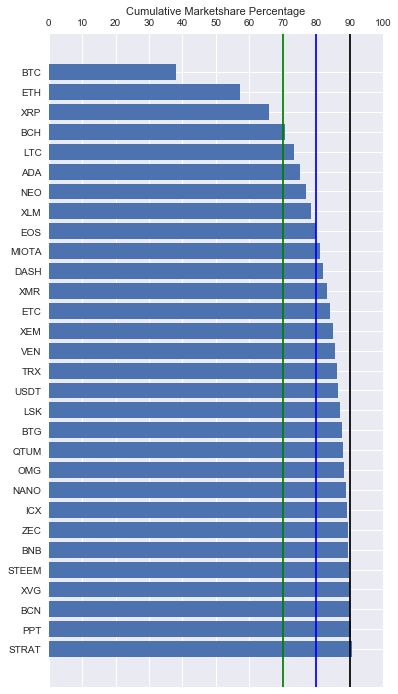

0     38.209299
1     57.306737
2     65.892469
3     70.562460
4     73.251422
5     75.215672
6     76.998796
7     78.509766
8     79.802536
9     81.022294
10    82.110435
11    83.109932
12    83.974256
13    84.808545
14    85.431653
15    86.051594
Name: market_cap_usd, dtype: float64


In [7]:
total_mkt_cap = gdf['total_market_cap_usd'][0]

fig, ax = plt.subplots(figsize=(6, 12))
ax.barh(df['rank'], 100*df['market_cap_usd'].cumsum()/total_mkt_cap)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Cumulative Marketshare Percentage')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

plt.axvline(x=70, color="green")
plt.axvline(x=80, color="blue")
plt.axvline(x=90, color="black")
plt.xticks(np.arange(0, 101, 10))

plt.show()

mktcap_cumsum = 100*df['market_cap_usd'].cumsum()/total_mkt_cap
print(mktcap_cumsum[:16])

By adjusting the `N_COINS` variable, we can see that the top 100 coins makes up approximately 95% of the market cap, while the top 5, 10, and 35 make up 70%, 80%, and 90% respectively. 


In [7]:
def top_n_perc(n):
    """
    Return the relative composition of the `top_n_perc` index as a dictionary.
    """
    ct = len([i for i in mktcap_cumsum if i < n])
    return {df['symbol'][i]: df['market_cap_usd'][i] for i in range(ct)}

print(top_n_perc(70))
print(top_n_perc(80))

{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438}
{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438, 'XLM': 10941377535, 'LTC': 9655024879, 'EOS': 8833621692, 'NEO': 8799375000, 'XEM': 7529435999, 'MIOTA': 6612224590}


We have set up an EC2 instance on AWS running CMC data collection (i.e. "we're on the cloud). We are currently collecting data on the top 30 coins every 5 minutes. 

##### Considering Historical Data

We have access to a limited amount of historical snapshots of coin market caps via. https://coinmarketcap.com/historical/.

The idea is to use these to inform our initial indicies, and then use our live data to track our initial indicies over time.

`TODO: Need Will's input on the number of coins to track & business knowledge on coins/indicies?`
`TODO: Once an initial index is decided, we will track it over time and display some analyses here`
